In [13]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import time

import shutil

import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch.nn.functional as F
import copy
import scipy.io
from sklearn.metrics import r2_score
import time

np.random.seed(54545467)
torch.manual_seed(54545467)


## Comment: This current setting had the best Test prediction done poinwise however this went off by large amount. Still unbeleivable!!!!!

In [14]:
encoded_size=3
BC_cond=4
time_Step=10

In [25]:
#Prevvious hidden=55 lr_decay=0.67

LSTM_parameters={'input_size':encoded_size+BC_cond,'hidden_size':56,
              'num_layers': 1,
              'output_size': encoded_size*time_Step}

trainer_info={'epochs': 200,
                'train_size': 6501,
                'train_batch':16,
                'test_batch': 4096,
                'lr0': 1e-3,
                'lr_decay': 0.69}


'''LSTM_parameters={'input_size':9,'hidden_size':60,
              'num_layers': 2,
              'output_size': 3}

trainer_info={'epochs': 600,
                'train_size': 6501,
                'train_batch': 16,
                'test_batch': 4096,
                'lr0': 1e-3,
                'lr_decay': 0.60}'''

print_freq=400
device = torch.device('cpu')
note = 'LSTM_DNN'
model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(LSTM_parameters['num_layers']) + 'layer_' + str(LSTM_parameters['hidden_size']) + 'hid_' + str(trainer_info['epochs']) + 'ep_' + note


In [16]:
class LSTM(nn.Module):
    def __init__(self,LSTM_parameters):
        super().__init__()

        input_size = LSTM_parameters['input_size']
        self.hidden_size = LSTM_parameters['hidden_size']
        self.num_layers = LSTM_parameters['num_layers']
        output_size = LSTM_parameters['output_size']

        self.leakrelu = torch.nn.LeakyReLU(negative_slope=0.01)
        
        self.tanh=torch.nn.Tanh()

        self.lstm1 = torch.nn.GRU(input_size, self.hidden_size, self.num_layers, batch_first=True)
    

        self.fc1 = torch.nn.Linear(self.hidden_size, output_size)

    def forward(self,x):

        a0=torch.zeros(self.num_layers,x.shape[0],self.hidden_size).to(device)

        c0=torch.zeros(self.num_layers,x.shape[0],self.hidden_size).to(device)

        #out,(a,c)=self.lstm1(x,(a0,c0))
        out,a=self.lstm1(x,(a0))
        
        #out=self.leakrelu(out)
        out = self.fc1(out)
        #out = self.leakrelu(out)

        return out
    
class DNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=torch.nn.Linear(in_features=encoded_size*time_Step,out_features=40,bias=True)
        self.fc2=torch.nn.Linear(in_features=40,out_features=80,bias=True)
        self.fc3=torch.nn.Linear(in_features=80, out_features=160,bias=True)
        self.fc4=torch.nn.Linear(in_features=160, out_features=encoded_size*time_Step,bias=True)
        '''self.fc5=torch.nn.Linear(in_features=320, out_features=640,bias=True)
        self.fc6=torch.nn.Linear(in_features=640, out_features=4,bias=True)'''
        self.actfunc=torch.nn.LeakyReLU(negative_slope=0.01)

    def forward(self,x):
     
        z1=self.fc1(x)
        a1=self.actfunc(z1)
 
        z2=self.fc2(a1)
        a2=self.actfunc(z2)
     

        z3=self.fc3(a2)
        a3=self.actfunc(z3)


        z4=self.fc4(a3)
        a4=self.actfunc(z4)
        '''z5=self.fc5(a4)
        a5=self.actfunc(z5)


        z6=self.fc6(a5)
        a6=self.actfunc(z6)'''
        
        return a4

class LSTMDNN(nn.Module):
    def __init__(self,LSTM_parameters):
        super().__init__()
        self.lstm=LSTM(LSTM_parameters)
        #self.dnn=DNN()

    def init_weights(self):
        with torch.set_grad_enabled(True):
            
            for name, param in self.named_parameters():
                print(f"Initializing parameter '{name}' with shape: {param.shape}")
                if 'weight' in name:
                    # Use one of the initialization methods
                    #nn.init.xavier_uniform_(param)
                    # nn.init.xavier_normal_(param)
                    # nn.init.kaiming_uniform_(param, nonlinearity='relu')
                     #nn.init.kaiming_normal_(param, nonlinearity='relu')
                    # nn.init.uniform_(param, a=-0.1, b=0.1)
                     #nn.init.normal_(param, mean=0.0, std=0.02)
                    nn.init.orthogonal_(param)
                    # nn.init.sparse_(param, sparsity=0.1)
                elif 'bias' in name:
                    nn.init.constant_(param, 0.0)

    def forward(self,x):
        out=self.lstm(x)

        #pred=self.dnn(out[:,out.shape[1]-1,:])
        return out[:,out.shape[1]-1,:]

In [5]:
class AverageMeter(object):
    # Computes and stores the average and current value

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.     # value
        self.avg = 0.     # averaged value
        self.sum = 0.
        self.count = 0.   # total number of values

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, inp, out):
        super().__init__()
        self.inp = inp
        self.out = out

    # This method overloads the built-in function len()
    def __len__(self):
        return self.inp.shape[0]

    # This method overloads the subscription operator '[]', when the object
    # is subscripted like X_train[], the system returns a tuple of objects.
    def __getitem__(self, index):
        return self.inp[index,:], self.out[index,:]

In [17]:
def train_step(train_loader, model, criterion, optimizer, epoch, net_info):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.to(device)
        target = target.to(device)

        # compute output
        output= model(input)
    
        loss = criterion(output, target)
        
        #print(enc)
        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # compute gradient and do the SGD step
        optimizer.zero_grad()
        loss.backward()
        
        '''for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"Gradient for parameter '{name}':\n{param.grad}")
            else:
                print(f"No gradient for parameter '{name}'")'''

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 25 == 0:
            if i % print_freq == 0:
                curr_lr = optimizer.param_groups[0]['lr']
                print('Epoch: [{0}/{1}][{2}/{3}]\t'
                    'LR: {4}\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.6f})\t'.format(
                    epoch, net_info['epochs'], i, len(train_loader), curr_lr,
                    batch_time=batch_time, data_time=data_time, loss=losses))
    return losses.avg


def test_step(test_loader, model, criterion, epoch):
    batch_time = AverageMeter()
    losses = AverageMeter()
    # violation = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(test_loader):

        input = input.to(device)
        target = target.to(device)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 25 == 0:
            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.4f})\t'.format(
                    i, len(test_loader), batch_time=batch_time, loss=losses))

    return losses.avg

#@title train_RNN()
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_LSTM_Tempo_Temperature_future.pth.tar')


In [18]:
def train_LSTM_DNN(model, net_info, train_loader, test_loader,LSTM_parameters):

    epochs = net_info['epochs']
    train_losses = np.empty([epochs, 1])
    test_losses = np.empty([epochs, 1])

    min_loss = 1e4

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'],weight_decay=1e-7)

    for epoch in range(epochs):
        # adjust learning rate
        if epoch >= 30:
            if epoch % 30 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= net_info['lr_decay']

        # train for one epoch
        train_losses_temp = train_step(train_loader, model, criterion, optimizer, epoch, net_info)
        train_losses[epoch] = train_losses_temp

        # evaluate on test set
        test_losses_temp = test_step(test_loader, model, criterion, epoch)
        test_losses[epoch] = test_losses_temp

        # remember best MSE and save checkpoint
        is_best = test_losses[epoch] < min_loss
        min_loss = min(test_losses[epoch], min_loss)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'min_loss': min_loss,
            'optimizer': optimizer.state_dict(),
        }, is_best)

    test_losses.tofile('test_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")
    train_losses.tofile('train_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")

    plt.figure(figsize=(10, 7))
    plt.plot(train_losses, label='training')
    plt.plot(test_losses, '--', label='test')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.title('Training and Test Loss\n(hidden size=%s, num layers=%s model'%(LSTM_parameters['hidden_size'],LSTM_parameters['num_layers']))
    plt.yscale('log')
    plt.legend()
    plt.show()
    return model

In [19]:
def main_program(T_S, T_S_out,val_T_S, val_T_S_out,LSTM_parameters, model,trainer_info, model_name):
    num_sample = trainer_info['train_size']
    T_S_train = T_S[:, :, :]
    T_S_out_train = T_S_out[:, :]
    training_set = MyDataset(T_S_train, T_S_out_train)

    T_S_test = val_T_S[:, :, :]
    T_S_out_test = val_T_S_out[:, :]
    val_set = MyDataset(T_S_test, T_S_out_test)

    # create training/test loaders
    train_loader = torch.utils.data.DataLoader(dataset=training_set,
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=val_set,
                                              batch_size=trainer_info['test_batch'],
                                              shuffle=True)

    model = train_LSTM_DNN(model, trainer_info, train_loader, test_loader,LSTM_parameters)
    torch.save(model.state_dict(), model_name)

    return model

In [20]:
In=loadmat("TrainingIn")
TrainIn=In['red_train'].astype(np.float32)
Out=loadmat("TrainingOut")
TrainOut=Out['red_train'].astype(np.float32)


In=loadmat("Validation_In")
ValIn=In['val_train'].astype(np.float32)
Out=loadmat("Validation_Out")
ValOut=Out['val_train'].astype(np.float32)

In=loadmat("Test_In")
TestIn=In['red_test'].astype(np.float32)
Out=loadmat("Test_Out")
TestOut=Out['red_test'].astype(np.float32)

time=loadmat("Input_BC")
time=time['BC'].astype(np.float32)[:,0]

hours=time/(3600)



In [21]:
'''In=loadmat("Test_In_NTI")
TestIn_NTI=In['red_test_NTI'].astype(np.float32)
Out=loadmat("Test_Out_NTI")
TestOut_NTI=Out['red_test_NTI'].astype(np.float32)'''


'In=loadmat("Test_In_NTI")\nTestIn_NTI=In[\'red_test_NTI\'].astype(np.float32)\nOut=loadmat("Test_Out_NTI")\nTestOut_NTI=Out[\'red_test_NTI\'].astype(np.float32)'

In [22]:

print(TrainIn.shape)
print(TrainOut.shape)
print(ValIn.shape)
print(ValOut.shape)

'''print(TestIn_NTI.shape)
print(TestOut_NTI.shape)'''


(6460, 10, 7)
(6460, 30)
(480, 10, 7)
(480, 30)


'print(TestIn_NTI.shape)\nprint(TestOut_NTI.shape)'

Epoch: [0/200][0/404]	LR: 0.001	Time 0.112 (0.112)	Data 0.002 (0.002)	Loss 0.0235297 (0.023530)	
Epoch: [0/200][400/404]	LR: 0.001	Time 0.004 (0.005)	Data 0.001 (0.001)	Loss 0.0000124 (0.001414)	
Test: [0/1]	Time 0.012 (0.012)	Loss 0.0000224 (0.0000)	
Epoch: [25/200][0/404]	LR: 0.001	Time 0.004 (0.004)	Data 0.001 (0.001)	Loss 0.0000027 (0.000003)	
Epoch: [25/200][400/404]	LR: 0.001	Time 0.004 (0.004)	Data 0.000 (0.001)	Loss 0.0000019 (0.000002)	
Test: [0/1]	Time 0.008 (0.008)	Loss 0.0000038 (0.0000)	
Epoch: [50/200][0/404]	LR: 0.00069	Time 0.004 (0.004)	Data 0.001 (0.001)	Loss 0.0000023 (0.000002)	
Epoch: [50/200][400/404]	LR: 0.00069	Time 0.004 (0.004)	Data 0.001 (0.001)	Loss 0.0000012 (0.000001)	
Test: [0/1]	Time 0.008 (0.008)	Loss 0.0000036 (0.0000)	
Epoch: [75/200][0/404]	LR: 0.0004760999999999999	Time 0.004 (0.004)	Data 0.001 (0.001)	Loss 0.0000014 (0.000001)	
Epoch: [75/200][400/404]	LR: 0.0004760999999999999	Time 0.004 (0.004)	Data 0.000 (0.001)	Loss 0.0000008 (0.000001)	
Test: 

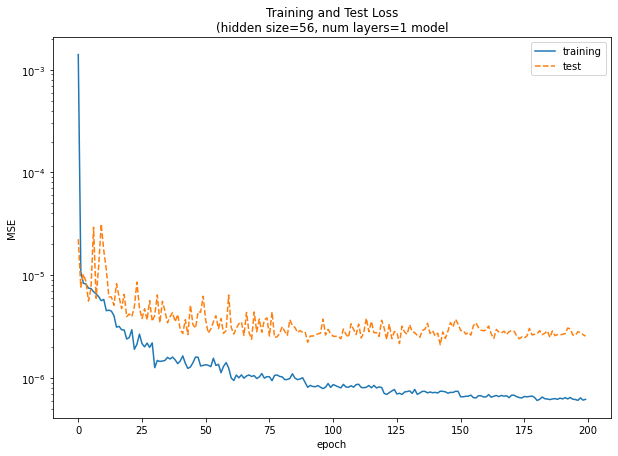

Total execution time: 357.77713084220886 seconds


In [13]:
'''import time
start_time = time.time()
model=LSTMDNN(LSTM_parameters).to(device)
model = main_program(TrainIn, TrainOut,ValIn,ValOut,LSTM_parameters,model, trainer_info, model_name)
end_time = time.time()
# Calculate and print the total execution time
total_execution_time = end_time - start_time
print(f"Total execution time: {total_execution_time} seconds")'''



In [26]:
#best_model_params = torch.load('model_best_LSTM_Tempo_Temperature.pth.tar', map_location=device)['state_dict']

#best_model_params = torch.load('model_LSTM_Tempo_Temperature_improving.pth.tar', map_location=device)['state_dict']

best_model_params = torch.load('model_LSTM_Tempo_Temperature_future.pth.tar', map_location=device)['state_dict']


In [27]:
model=LSTMDNN(LSTM_parameters).to(device)
model.load_state_dict(best_model_params)

<All keys matched successfully>

In [28]:
time_step=10

In [29]:
Test=loadmat('Test_Inital.mat')
Test_init=Test['Test']
BC_test=loadmat('BC_test.mat')

BC=BC_test['BC_test'][time_step:]
print(BC_test['BC_test'].shape)
Test_init=torch.from_numpy(Test_init).float().to(device)

BC=torch.from_numpy(BC).float().to(device)

print(BC.shape)


(1511, 4)
torch.Size([1501, 4])


In [19]:
'''Test=loadmat('Test_Inital_NTI.mat')
Test_init_NTI=Test['Test']
BC_test=loadmat('BC_test_NTI.mat')

BC_NTI=BC_test['BC_test'][time_step:]
print(BC_test['BC_test'].shape)
Test_init_NTI=torch.from_numpy(Test_init_NTI).float().to(device)

BC_NTI=torch.from_numpy(BC_NTI).float().to(device)

print(BC_NTI.shape)'''

"Test=loadmat('Test_Inital_NTI.mat')\nTest_init_NTI=Test['Test']\nBC_test=loadmat('BC_test_NTI.mat')\n\nBC_NTI=BC_test['BC_test'][time_step:]\nprint(BC_test['BC_test'].shape)\nTest_init_NTI=torch.from_numpy(Test_init_NTI).float().to(device)\n\nBC_NTI=torch.from_numpy(BC_NTI).float().to(device)\n\nprint(BC_NTI.shape)"

In [19]:
'''print(BC_test['BC_test'][:time_step])'''


"print(BC_test['BC_test'][:time_step])"

In [20]:
'''print(Test_init.shape)'''

'print(Test_init.shape)'

In [ ]:
'''print(Test_init_NTI.shape)'''

In [ ]:
'''## Comparing. Test_out(actual vs predicted step by step)
error=np.zeros((3000,1))
prediction=torch.zeros([3000,encoded_size]).to(device)
for i in range(3000):
    prediction[i,:]=model(Test_init)
    #prediction[i,:]=Test_init[:,-1,0:encoded_size]+prediction[i,:]
    error[i]=np.linalg.norm(np.abs(prediction.cpu().detach().numpy()[i,:]-TestOut[i,:]))
    Test_init_tmp=torch.zeros([1,time_step,encoded_size+BC_cond]).float().to(device)
    
    Test_init_tmp[0,:-1,0:encoded_size+BC_cond]=Test_init[0,1:,0:encoded_size+BC_cond]
    Test_init_tmp[0,-1,0:encoded_size]=prediction[i,0:encoded_size]
    Test_init_tmp[0,-1,encoded_size:]=BC[i,:]
    Test_init=Test_init_tmp.clone()
plt.figure(1)
plt.plot(error)'''

In [ ]:
# Predictions Test
'''prediction=torch.zeros([3000,encoded_size]).to(device)
for i in range(3000):
    '''print(Test_init)
    print(i)'''
    prediction[i,:]=model(Test_init)
    #prediction[i,:]=Test_init[:,-1,0:encoded_size]+prediction[i,:]
    
    Test_init_tmp=torch.zeros([1,time_step,encoded_size+BC_cond]).float().to(device)
    Test_init_tmp[0,:-1,0:encoded_size+BC_cond]=Test_init[0,1:,0:encoded_size+BC_cond]
    Test_init_tmp[0,-1,0:encoded_size]=prediction[i,0:encoded_size]
    Test_init_tmp[0,-1,encoded_size:]=BC[i,:]
    Test_init=Test_init_tmp.clone()'''


In [15]:
## For Multiple output 
predictions=torch.zeros([int(3000/time_Step),encoded_size*time_step])
p=0

for i in range(int(3000/time_Step)):
    #print(Test_init)
    predictions[i,:]=model(Test_init)
    Test_init[:,:,0:encoded_size]=predictions[i,:].reshape(1,time_step,encoded_size)
    Test_init[0,:,encoded_size:]=BC[p:p+time_step,:]
    p=p+time_step
    
prediction=torch.zeros([3000,encoded_size])
k=0
for i in range(int(3000/time_Step)):
    l=0
    for j in range(time_Step):
        prediction[k,:]=predictions[i,l:l+3]
        k=k+1
        l=l+3

In [30]:
## For Multiple output 
predictions=torch.zeros([int(1501/time_Step),encoded_size*time_step])
p=0

for i in range(int(1501/time_Step)):
    #print(Test_init)
    predictions[i,:]=model(Test_init)
    Test_init[:,:,0:encoded_size]=predictions[i,:].reshape(1,time_step,encoded_size)
    Test_init[0,:,encoded_size:]=BC[p:p+time_step,:]
    p=p+time_step
    
prediction=torch.zeros([1501,encoded_size])
k=0
for i in range(int(1501/time_Step)):
    l=0
    for j in range(time_Step):
        prediction[k,:]=predictions[i,l:l+encoded_size]
        k=k+1
        l=l+encoded_size

In [31]:
print(prediction)

tensor([[-0.0326, -0.0251, -0.2005],
        [-0.0326, -0.0252, -0.2007],
        [-0.0327, -0.0252, -0.2010],
        ...,
        [-0.0264, -0.0542, -0.2409],
        [-0.0266, -0.0544, -0.2414],
        [ 0.0000,  0.0000,  0.0000]], grad_fn=<CopySlices>)


In [ ]:
## For multiple output No thermal invrerison
'''predictions=torch.zeros([850,encoded_size*time_step])
p=0
for i in range(int(8500/time_Step)):
    #print(Test_init)
    predictions[i,:]=model(Test_init_NTI)
    Test_init_NTI[:,:,0:encoded_size]=predictions[i,:].reshape(1,time_step,encoded_size)
    Test_init_NTI[0,:,encoded_size:]=BC_NTI[p:p+time_step,:]
    p=p+time_step
    
prediction=torch.zeros([8500,encoded_size])
k=0
for i in range(int(8500/time_Step)):
    l=0
    for j in range(time_Step):
        prediction[k,:]=predictions[i,l:l+3]
        k=k+1
        l=l+3'''

In [ ]:
'''print(prediction[7999])'''

In [ ]:
'''for i in range(3000):
    print(torch.from_numpy(TestIn[i,:,:]))
    print(i)'''

In [ ]:
'''prediction=torch.zeros([3000,3])
for i in range(3000):
    prediction[i,:]=model(Test_init)
    Test_init[0,:-1,0:5]=Test_init[0,1:,0:5]
    Test_init[0,-1,0:3]=prediction[i,0:3]
    Test_init[0,-1,3:5]=BC[i,:]'''
   

In [32]:
filename='predictions_encodings.mat'
predictions_enc={'pred':prediction.cpu().detach().numpy()}

scipy.io.savemat(filename,predictions_enc)

print(prediction.shape)


torch.Size([1501, 3])


In [ ]:
'''print(ValIn[:,-1,0:encoded_size].shape)'''

In [ ]:
# Comparison between Actual reduced state to the predicted reduced state by LSTM-DNN for Validation dataset

'''Predicted_reduced_state=model(torch.from_numpy(ValIn).float().to(device))#+torch.from_numpy(ValIn[:,-1,0:encoded_size]).float().to(device)

ValOut=(ValOut)#+(ValIn[:,-1,0:encoded_size])
print(Predicted_reduced_state.shape)
print(ValOut.shape)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(ValOut[::10, 0], Predicted_reduced_state.cpu().detach().numpy()[::10, 0])
ax[0].plot((np.min(ValOut[::10, 0]), np.max(ValOut[::10, 0])), 
           (np.min(ValOut[::10, 0]), np.max(ValOut[::10, 0]))) 

ax[1].scatter(ValOut[::10, 1], Predicted_reduced_state.cpu().detach().numpy()[::10, 1])
ax[1].plot((np.min(ValOut[::10, 1]), np.max(ValOut[::10, 1])), 
           (np.min(ValOut[::10, 1]), np.max(ValOut[::10, 1])))  

ax[2].scatter(ValOut[::10, 2], Predicted_reduced_state.cpu().detach().numpy()[::10, 2])
ax[2].plot((np.min(ValOut[::10, 2]), np.max(ValOut[::10, 2])), 
           (np.min(ValOut[::10, 2]), np.max(ValOut[::10, 2]))) 
'''
'''ax[3].scatter(ValOut[::10, 3], Predicted_reduced_state.cpu().detach().numpy()[::10, 3])
ax[3].plot((np.min(ValOut[::10, 3]), np.max(ValOut[::10, 3])), 
           (np.min(ValOut[::10, 3]), np.max(ValOut[::10, 3])))''' 
'''ax[4].scatter(ValOut[::10, 4], Predicted_reduced_state.cpu().detach().numpy()[::10, 4])
ax[4].plot((np.min(ValOut[::10, 4]), np.max(ValOut[::10, 4])), 
           (np.min(ValOut[::10, 4]), np.max(ValOut[::10, 4]))) '''

'''plt.show()

print(r2_score(ValOut[:,0],Predicted_reduced_state.cpu().detach().numpy()[:,0]))
print(r2_score(ValOut[:,1],Predicted_reduced_state.cpu().detach().numpy()[:,1]))
print(r2_score(ValOut[:,2],Predicted_reduced_state.cpu().detach().numpy()[:,2]))
#print(r2_score(ValOut[:,3],Predicted_reduced_state.cpu().detach().numpy()[:,3]))'''
'''print(r2_score(ValOut[:,4],Predicted_reduced_state.cpu().detach().numpy()[:,4]))'''

In [ ]:
'''# Comparison between Actual reduced state to the predicted reduced state by LSTM-DNN for Testing dataset

Predicted_reduced_state=model(torch.from_numpy(TestIn).float().to(device)) #+ torch.from_numpy(TestIn[:,-1,0:encoded_size]).float().to(device)
TestOut=(TestOut)#+(TestIn[:,-1,0:encoded_size])


print(Predicted_reduced_state.shape)
print(TestOut.shape)

Start=0
End=1000
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(TestOut[0:1000:5, 0], Predicted_reduced_state.cpu().detach().numpy()[0:1000:5, 0])
ax[0].plot((np.min(TestOut[0:1000:5, 0]), np.max(TestOut[0:1000:5, 0])), 
           (np.min(TestOut[0:1000:5, 0]), np.max(TestOut[0:1000:5, 0]))) 

ax[1].scatter(TestOut[0:1000:5, 1], Predicted_reduced_state.cpu().detach().numpy()[0:1000:5, 1])
ax[1].plot((np.min(TestOut[0:1000:5, 1]), np.max(TestOut[0:1000:5, 1])), 
           (np.min(TestOut[0:1000:5, 1]), np.max(TestOut[0:1000:5, 1])))  

ax[2].scatter(TestOut[0:1000:5, 2], Predicted_reduced_state.cpu().detach().numpy()[0:1000:5, 2])
ax[2].plot((np.min(TestOut[0:1000:5, 2]), np.max(TestOut[0:1000:5, 2])), 
           (np.min(TestOut[0:1000:5, 2]), np.max(TestOut[0:1000:5, 2]))) 

plt.show()

print(r2_score(TestOut[0:1000:5,0],Predicted_reduced_state.cpu().detach().numpy()[0:1000:5,0]))
print(r2_score(TestOut[0:1000:5,1],Predicted_reduced_state.cpu().detach().numpy()[0:1000:5,1]))
print(r2_score(TestOut[0:1000:5,2],Predicted_reduced_state.cpu().detach().numpy()[0:1000:5,2]))'''

In [ ]:
'''filename6='Testset_predicted_encodings.mat'
test={'Actual1':TestOut,'Predicted1':Predicted_reduced_state.cpu().detach().numpy()}

scipy.io.savemat(filename6,test)


filename='predictions_encodings_testset.mat'
predictions_enc={'pred':Predicted_reduced_state.cpu().detach().numpy()}

scipy.io.savemat(filename,predictions_enc)'''

In [33]:


Test=loadmat('Test_Set.mat')
Test_encodings_actual=Test['Test_Set']

In [ ]:
print(Test_encodings_actual)

In [ ]:
'''Test=loadmat('Test_Set_NTI.mat')
Test_encodings_actual=Test['Test_Set']'''

In [ ]:
'''print(TestOut.shape)
print(Test_encodings_actual.shape)'''

In [ ]:
'''print(Test_encodings_actual)
print(Test_encodings_actual.shape)'''

In [34]:
print(prediction)
print(prediction.shape)

filename6='Test_actual_predicted_encodings.mat'
test={'Actual':Test_encodings_actual,'Predicted':prediction.cpu().detach().numpy()}

scipy.io.savemat(filename6,test)


tensor([[-0.0326, -0.0251, -0.2005],
        [-0.0326, -0.0252, -0.2007],
        [-0.0327, -0.0252, -0.2010],
        ...,
        [-0.0264, -0.0542, -0.2409],
        [-0.0266, -0.0544, -0.2414],
        [ 0.0000,  0.0000,  0.0000]], grad_fn=<CopySlices>)
torch.Size([1501, 3])


In [ ]:
'''print(prediction[1000,:])
print(Test_encodings_actual[1000,:])'''

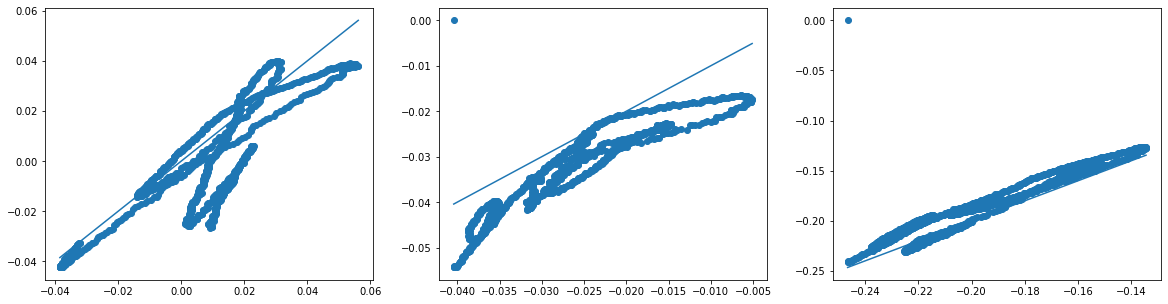

0.387938531117645
0.2740614194111246
0.7914255831120185


In [35]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
Start=0
End=3000
stride=1

ax[0].scatter(Test_encodings_actual[Start:End:stride, 0], prediction.cpu().detach().numpy()[Start:End:stride, 0])
ax[0].plot((np.min(Test_encodings_actual[Start:End:stride, 0]), np.max(Test_encodings_actual[Start:End:stride, 0])), 
           (np.min(Test_encodings_actual[Start:End:stride, 0]), np.max(Test_encodings_actual[Start:End:stride, 0])))  # Corrected line

ax[1].scatter(Test_encodings_actual[Start:End:stride, 1], prediction.cpu().detach().numpy()[Start:End:stride, 1])
ax[1].plot((np.min(Test_encodings_actual[Start:End:stride, 1]), np.max(Test_encodings_actual[Start:End:stride, 1])), 
           (np.min(Test_encodings_actual[Start:End:stride, 1]), np.max(Test_encodings_actual[Start:End:stride, 1])))  # Corrected line

ax[2].scatter(Test_encodings_actual[Start:End:stride, 2], prediction.cpu().detach().numpy()[Start:End:stride, 2])
ax[2].plot((np.min(Test_encodings_actual[Start:End:stride, 2]), np.max(Test_encodings_actual[Start:End:stride, 2])), 
           (np.min(Test_encodings_actual[Start:End:stride, 2]), np.max(Test_encodings_actual[Start:End:stride, 2])))  # Corrected line

'''ax[3].scatter(Test_encodings_actual[::10, 3], prediction.cpu().detach().numpy()[::10, 3])
ax[3].plot((np.min(Test_encodings_actual[::10, 3]), np.max(Test_encodings_actual[::10, 3])), 
           (np.min(Test_encodings_actual[::10, 3]), np.max(Test_encodings_actual[::10, 3]))) '''

'''ax[4].scatter(Test_encodings_actual[::10, 4], prediction.cpu().detach().numpy()[::10, 4])
ax[4].plot((np.min(Test_encodings_actual[::10, 4]), np.max(Test_encodings_actual[::10, 4])), 
           (np.min(Test_encodings_actual[::10, 4]), np.max(Test_encodings_actual[::10, 4]))) 
'''
plt.show()


print(r2_score(Test_encodings_actual[Start:End:stride,0],prediction.cpu().detach().numpy()[Start:End:stride,0]))
print(r2_score(Test_encodings_actual[Start:End:stride,1],prediction.cpu().detach().numpy()[Start:End:stride,1]))
print(r2_score(Test_encodings_actual[Start:End:stride,2],prediction.cpu().detach().numpy()[Start:End:stride,2]))
#print(r2_score(Test_encodings_actual[:,3],prediction.cpu().detach().numpy()[:,3]))
#print(r2_score(Test_encodings_actual[:,4],prediction.cpu().detach().numpy()[:,4]))

Text(0.5, 0.98, 'Evolution of three Latent space variables ')

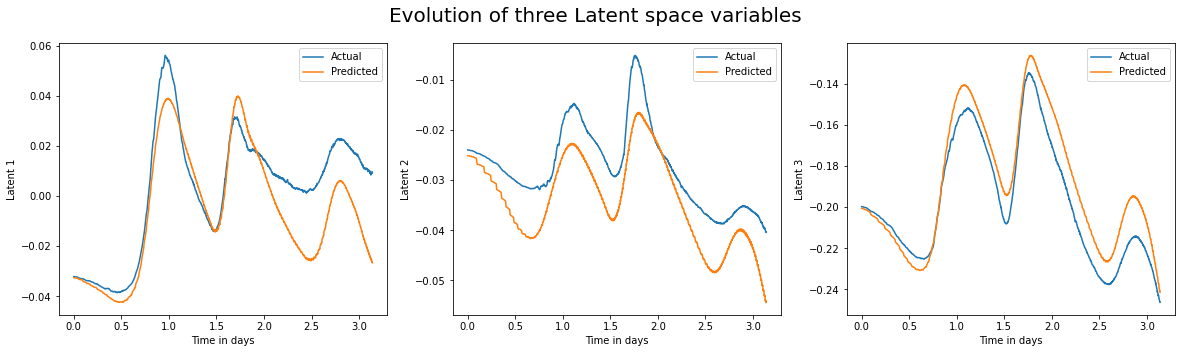

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
Start=0
End=1500
stride=1
days=hours/24
ax[0].plot(days[Start:End],Test_encodings_actual[Start:End:stride, 0],label='Actual')
ax[0].plot(days[Start:End],prediction.cpu().detach().numpy()[Start:End:stride, 0],label='Predicted')
ax[0].set_xlabel('Time in days')
ax[0].set_ylabel('Latent 1')

ax[1].plot(days[Start:End],Test_encodings_actual[Start:End:stride, 1],label='Actual')
ax[1].plot(days[Start:End],prediction.cpu().detach().numpy()[Start:End:stride, 1],label='Predicted')
ax[1].set_xlabel('Time in days')
ax[1].set_ylabel('Latent 2')

ax[2].plot(days[Start:End],Test_encodings_actual[Start:End:stride, 2],label='Actual')
ax[2].plot(days[Start:End],prediction.cpu().detach().numpy()[Start:End:stride, 2],label='Predicted')
ax[2].set_xlabel('Time in days')
ax[2].set_ylabel('Latent 3')


ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.suptitle('Evolution of three Latent space variables ',fontsize=20)



In [41]:
red_al=loadmat('reduced_all.mat')
red_al=red_al['red_all']

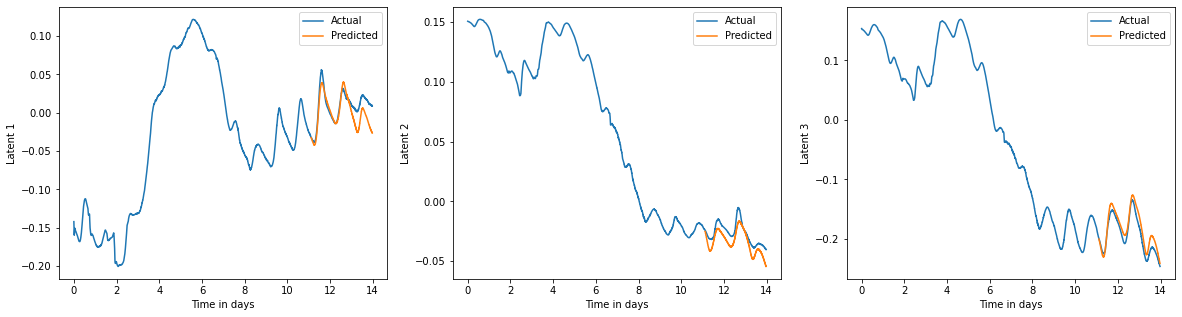

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
Start=0
End=1500
stride=1
days=hours/24

ax[0].plot(days,red_al[:, 0],label='Actual')
ax[0].plot(days[Start+7000:End+7000],prediction.cpu().detach().numpy()[Start:End:stride, 0],label='Predicted')
ax[0].set_xlabel('Time in days')
ax[0].set_ylabel('Latent 1')

ax[1].plot(days,red_al[:, 1],label='Actual')
ax[1].plot(days[Start+7000:End+7000],prediction.cpu().detach().numpy()[Start:End:stride, 1],label='Predicted')
ax[1].set_xlabel('Time in days')
ax[1].set_ylabel('Latent 2')

ax[2].plot(days,red_al[:, 2],label='Actual')
ax[2].plot(days[Start+7000:End+7000],prediction.cpu().detach().numpy()[Start:End:stride, 2],label='Predicted')
ax[2].set_xlabel('Time in days')
ax[2].set_ylabel('Latent 3')

ax[0].legend()
ax[1].legend()
ax[2].legend()


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(Test_encodings_actual[::10, 0], prediction.cpu().detach().numpy()[::10, 0])
ax[0].plot((np.min(Test_encodings_actual[::10, 0]), np.max(Test_encodings_actual[::10, 0])), 
           (np.min(Test_encodings_actual[::10, 0]), np.max(Test_encodings_actual[::10, 0])))  # Corrected line

ax[1].scatter(Test_encodings_actual[::10, 1], prediction.cpu().detach().numpy()[::10, 1])
ax[1].plot((np.min(Test_encodings_actual[::10, 1]), np.max(Test_encodings_actual[::10, 1])), 
           (np.min(Test_encodings_actual[::10, 1]), np.max(Test_encodings_actual[::10, 1])))  # Corrected line

ax[2].scatter(Test_encodings_actual[::10, 2], prediction.cpu().detach().numpy()[::10, 2])
ax[2].plot((np.min(Test_encodings_actual[::10, 2]), np.max(Test_encodings_actual[::10, 2])), 
           (np.min(Test_encodings_actual[::10, 2]), np.max(Test_encodings_actual[::10, 2])))  # Corrected line

'''ax[3].scatter(Test_encodings_actual[::10, 3], prediction.cpu().detach().numpy()[::10, 3])
ax[3].plot((np.min(Test_encodings_actual[::10, 3]), np.max(Test_encodings_actual[::10, 3])), 
           (np.min(Test_encodings_actual[::10, 3]), np.max(Test_encodings_actual[::10, 3]))) '''

'''ax[4].scatter(Test_encodings_actual[::10, 4], prediction.cpu().detach().numpy()[::10, 4])
ax[4].plot((np.min(Test_encodings_actual[::10, 4]), np.max(Test_encodings_actual[::10, 4])), 
           (np.min(Test_encodings_actual[::10, 4]), np.max(Test_encodings_actual[::10, 4]))) 
'''
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(Test_encodings_actual[0:100, 0], prediction.cpu().detach().numpy()[0:100, 0])
ax[0].plot((np.min(Test_encodings_actual[0:100, 0]), np.max(Test_encodings_actual[0:100, 0])), 
           (np.min(Test_encodings_actual[0:100, 0]), np.max(Test_encodings_actual[0:100, 0])))  # Corrected line

ax[1].scatter(Test_encodings_actual[0:100, 1], prediction.cpu().detach().numpy()[0:100, 1])
ax[1].plot((np.min(Test_encodings_actual[0:100, 1]), np.max(Test_encodings_actual[0:100, 1])), 
           (np.min(Test_encodings_actual[0:100, 1]), np.max(Test_encodings_actual[0:100, 1])))  # Corrected line

ax[2].scatter(Test_encodings_actual[0:100, 2], prediction.cpu().detach().numpy()[0:100, 2])
ax[2].plot((np.min(Test_encodings_actual[0:100, 2]), np.max(Test_encodings_actual[0:100, 2])), 
           (np.min(Test_encodings_actual[0:100, 2]), np.max(Test_encodings_actual[0:100, 2])))  # Corrected line

'''ax[3].scatter(Test_encodings_actual[::10, 3], prediction.cpu().detach().numpy()[::10, 3])
ax[3].plot((np.min(Test_encodings_actual[::10, 3]), np.max(Test_encodings_actual[::10, 3])), 
           (np.min(Test_encodings_actual[::10, 3]), np.max(Test_encodings_actual[::10, 3]))) '''

'''ax[4].scatter(Test_encodings_actual[::10, 4], prediction.cpu().detach().numpy()[::10, 4])
ax[4].plot((np.min(Test_encodings_actual[::10, 4]), np.max(Test_encodings_actual[::10, 4])), 
           (np.min(Test_encodings_actual[::10, 4]), np.max(Test_encodings_actual[::10, 4]))) 
'''
plt.show()

print(r2_score(Test_encodings_actual[:,0],prediction.cpu().detach().numpy()[:,0]))
print(r2_score(Test_encodings_actual[:,1],prediction.cpu().detach().numpy()[:,1]))
print(r2_score(Test_encodings_actual[:,2],prediction.cpu().detach().numpy()[:,2]))